# Домашнее задание: основы DL

## Задание 1

Вспомним 1ое зянятие - мы узнали, что в DL мы можем подбирать оптимальные параметры для любой дифференцируемой модели, считая градиенты по обучаемым параметрам. 

В этом задании вам предстоит руками сделать backpropagation для совсем простой модели, чтобы понять, что в torch не происходит никакой магии




Пусть: 

$x = [1, 1]^T$

$y = [1, -1]^T$

$z = [-1, 2]^T$


$l = sum(max(0, x*y)) + prod(x + z^2)$

где $sum, prod$ - поэлементные сложения и умножения соответственно



В ответ вам нужно указать $\frac{\partial l}{\partial x}$ и $\frac{\partial l}{\partial z}$, а в ноутбуке отобразить, как вы аналитически получили это значение

Для проверки, что вы правильно поняли идею backpropagation, можете подсчитать значение $\frac{\partial l}{\partial y}$, оно должно проходить assert

$l = sum(max(0, x*y)) + prod(x + z^2) = sum\left(\begin{bmatrix} max\left(0,\; x_1\cdot y_1\right) \\ max\left(0,\; x_2\cdot  y_2\right)  \end{bmatrix}\right) + (x_1 + z_1^2)(x_2 + z_2^2) =$

$= max\left(0,\; x_1\cdot y_1\right) + max\left(0,\; x_2\cdot  y_2\right) + (x_1 + z_1^2)(x_2 + z_2^2)$

Посчитаем производную по x при условии что $y_1 > 0$, $y_2 < 0$, $x_1 > 0$, $x_2 > 0$

$\dfrac{dl}{dx} =  [y_1 +  x_2 + z_2^2,\;x_1 + z_1^2] $

Подставляем $x,\;y,\;z$: $ \dfrac{dl}{dx}([1, 1]^T,  [1, -1]^T, [-1, 2]^T) = [6,\;2]$

Посчитаем производную по y при условии что $y_1 > 0$, $y_2 < 0$, $x_1 > 0$, $x_2 > 0$

$\dfrac{dl}{dy} =  [x_1,\;0] $

Подставляем  $x,\;y,\;z$: $ \dfrac{dl}{dy}([1, 1]^T,  [1, -1]^T, [-1, 2]^T) = [1,\;0]$


Посчитаем производную по z

$\dfrac{dl}{dz} =  [2z_1x_2 + 2z_1z_2^2,\; 2z_2x_1 + 2z_2z_1^2] $

Подставляем  $x,\;y,\;z$: $ \dfrac{dl}{dz}([1, 1]^T,  [1, -1]^T, [-1, 2]^T) = [-10, \;8]$

In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

In [2]:
dl_dy = [1, 0]
assert np.all(dl_dy == [1, 0]), "Пока что неверное, попробуйте еще раз и все получится!"

# Задание 2

На занятиях мы часто говорили про линейные модели, что это просто. Давайте реализуем ее сами и попробуем обучать такую модель для задачи классификации (то есть реализуем логистическую регрессию)

На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. 

Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. 

Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. 

Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

## Задание 2.0

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры ([`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).



In [3]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features), requires_grad=True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features), requires_grad=True)

    def forward(self, x):

        res = x @ self.weights
        if self.bias:
            res += self.bias_term
        return res

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [4]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

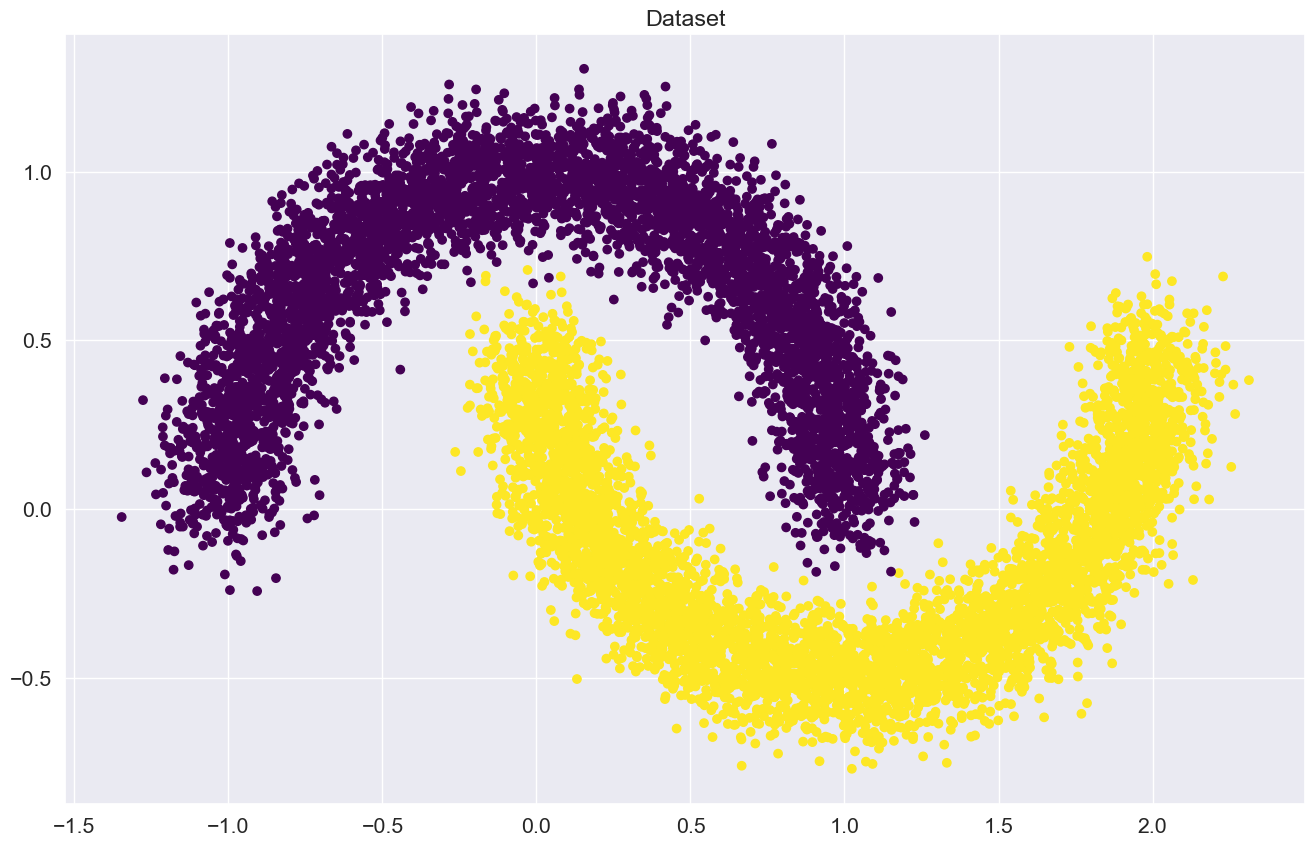

In [5]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [7]:
X_train.shape

(7500, 2)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [8]:
X_train_t =  torch.from_numpy(X_train.astype(np.float32))
y_train_t =  torch.from_numpy(y_train.astype(np.float32))
X_val_t =  torch.from_numpy(X_val.astype(np.float32))
y_val_t =  torch.from_numpy(y_val.astype(np.float32))

Создаем `Dataset` и `DataLoader`.

In [9]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [10]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1, True)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

## Задание 2.1 Сколько обучаемых параметров у получившейся модели?

**Ответ:** ... (необходимо внести в форму)

In [11]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[0.3367],
         [0.1288]], requires_grad=True),
 Parameter containing:
 tensor([0.2345], requires_grad=True)]

Итого 3 обучаемых параметра

## Задание 2.2

Теперь обучим эту модель

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
prev_bias = torch.zeros_like(linear_regression.bias_term)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) 
        loss = loss_function(outp.view(-1), y_batch) 
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        sigm = nn.Sigmoid()
        probabilities =  sigm(outp)
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        current_bias = linear_regression.bias_term.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol and (prev_bias - current_bias).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
        prev_bias = current_bias
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5625
Iteration: 7500
Batch accuracy: 0.765625
Iteration: 15000
Batch accuracy: 0.7890625
Iteration: 22500
Batch accuracy: 0.7890625
Iteration: 30000
Batch accuracy: 0.8046875
Iteration: 37500
Batch accuracy: 0.8046875
Iteration: 45000
Batch accuracy: 0.8046875
Iteration: 52500
Batch accuracy: 0.8203125
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8203125
Iteration: 75000
Batch accuracy: 0.8203125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.8203125
Iteration: 97500
Batch accuracy: 0.828125
Iteration: 105000
Batch accuracy: 0.828125

Iteration: 105054.Convergence. Stopping iterations.


## Задание 2.2

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** необходимо указать в форме

### Визуализируем результаты

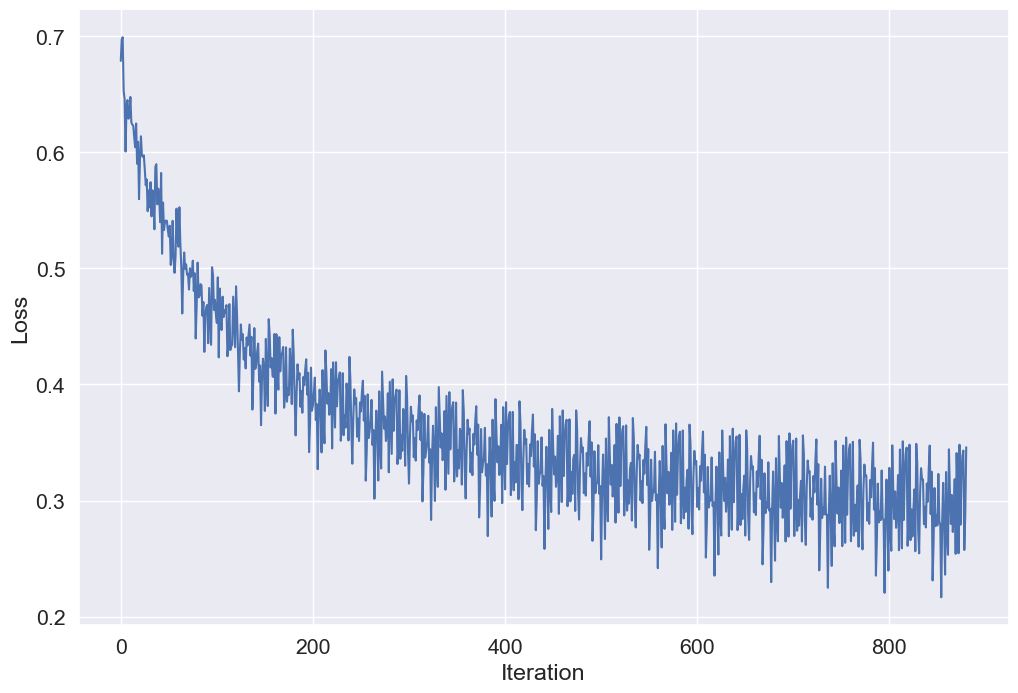

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score

out = predict(val_dataloader, linear_regression)
print(accuracy_score(out, y_val_t))

0.8688


## Задание 2.3

Какое `accuracy` получается после обучения?

**Ответ:** необходимо указать в форме

0.8688


# Задание 3

Теперь перейдем к датасету MNIST!

На 2ом и 3ем семинаре мы работали с этим датасетом, поэтому ваша задача взять код от туда и исследовать такой интересный вопрос: какая функция активации лучше всего подходит под эту задачу? 


Вам необходимо обучить 4 раза модель ниже и сравнить качество для различных функций активаций (или их отсутствия)

In [16]:
from ipywidgets import FloatProgress
from tqdm.notebook import tqdm
import torchvision

In [17]:
# используем готовый класс от торча для загрузки данных для тренировки
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

# так как это уже унаследованный от Dataset класс, его можно сразу обернуть в даталоадер
train_dataloader = torch.utils.data.DataLoader(
    mnist_train, batch_size=4, shuffle=True,
)

val_dataloader = torch.utils.data.DataLoader(
    mnist_val, batch_size=4, shuffle=False,
)

In [18]:
percent = 0

In [24]:
from IPython.display import clear_output

def no_act_training():
    global percent
    
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        nn.Linear(128, 128),
        nn.Linear(128, 10)
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    
    
    max_epoch = 10
    accuracies = []
    for epoch in range(max_epoch):
        clear_output(True)
        print(f'progress: {round(percent * 100, 2)}%')
        percent += 0.025
        for x_train, y_train in tqdm(train_dataloader):  # берем батч из трейн лоадера
            y_pred = model(x_train)  # делаем предсказания
            loss = F.cross_entropy(y_pred, y_train)  # считаем лосс
            loss.backward()  # считаем градиенты обратным проходом
            optimizer.step()  # обновляем параметры сети
            optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров


        val_loss = []  # сюда будем складывать **средний по бачу** лосс
        val_accuracy = []
        with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
            for x_val, y_val in tqdm(val_dataloader):  # берем батч из валидационного лоадера
                y_pred = model(x_val)  # делаем предсказания
                loss = F.cross_entropy(y_pred, y_val)  # считаем лосс
                val_loss.append(loss.numpy())  # добавляем в массив
                val_accuracy.extend(
                    (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
                )
        
        accuracies.append(np.mean(val_accuracy))
    return accuracies

def training(activation):
    global percent
    
    activation = activation  # нужно перебрать: no_activation, ReLU, LeakyReLU, ELU

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    
    max_epoch = 10
    accuracies = []
    for epoch in range(max_epoch):
        clear_output(True)
        print(f'progress: {round(percent * 100, 2)}%')
        percent += 0.025
        for x_train, y_train in tqdm(train_dataloader):  # берем батч из трейн лоадера
            y_pred = model(x_train)  # делаем предсказания
            loss = F.cross_entropy(y_pred, y_train)  # считаем лосс
            loss.backward()  # считаем градиенты обратным проходом
            optimizer.step()  # обновляем параметры сети
            optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров


        val_loss = []  # сюда будем складывать **средний по бачу** лосс
        val_accuracy = []
        with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
            for x_val, y_val in tqdm(val_dataloader):  # берем батч из валидационного лоадера
                y_pred = model(x_val)  # делаем предсказания
                loss = F.cross_entropy(y_pred, y_val)  # считаем лосс
                val_loss.append(loss.numpy())  # добавляем в массив
                val_accuracy.extend(
                    (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
                )
        
        accuracies.append(np.mean(val_accuracy))
    return accuracies
        

Необходимо построить график: valid accuracy от номера эпохи (максимум 10 эпох) для разных функций активации и выбрать лучшую из них

progress: 97.5%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

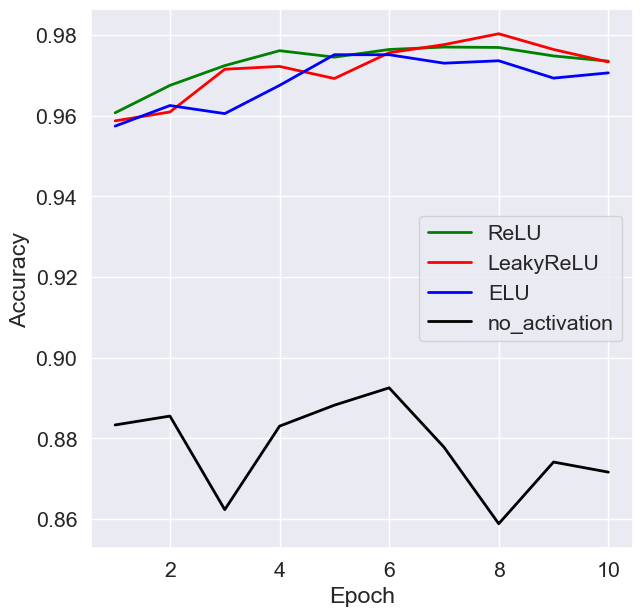

In [25]:
percent = 0

funcs = [nn.ReLU, nn.LeakyReLU, nn.ELU]
names = ["ReLU", "LeakyReLU", "ELU", "no_activation"]
colors = ["green", "red", "blue", "black"]
plt.figure(figsize=(7, 7), dpi=100)

relu_accuracy = training(nn.ReLU)

leaky_relu_accuracy = training(nn.LeakyReLU)

elu_accuracy = training(nn.ELU)

no_activation_accuracy = no_act_training()

epoches = list(range(1,11))

plt.plot(epoches, relu_accuracy, color="green", linewidth=2, label="ReLU")
plt.plot(epoches, leaky_relu_accuracy, color="red", linewidth=2, label="LeakyReLU")
plt.plot(epoches, elu_accuracy, color="blue", linewidth=2, label="ELU")
plt.plot(epoches, no_activation_accuracy, color="black", linewidth=2, label="no_activation")


plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


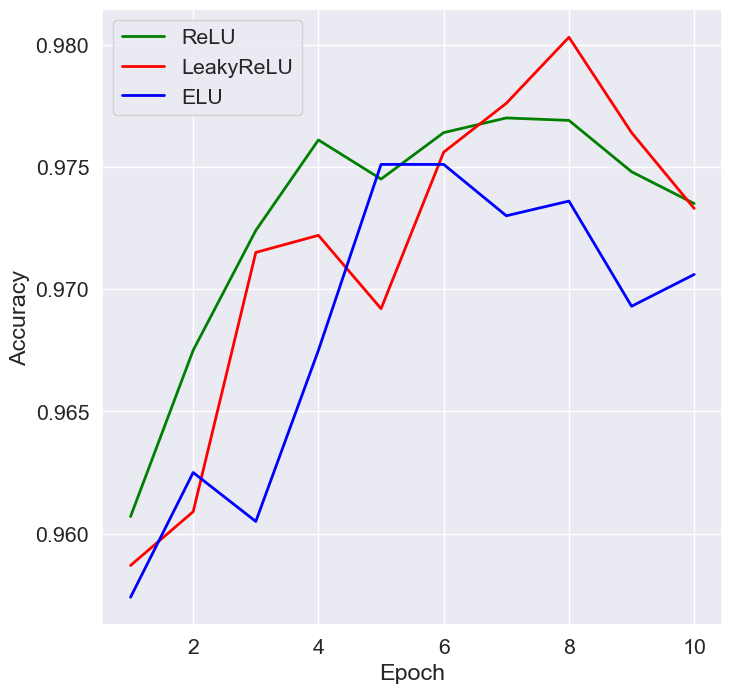

In [28]:
plt.figure(figsize=(8, 8), dpi=100)
plt.plot(epoches, relu_accuracy, color="green", linewidth=2, label="ReLU")
plt.plot(epoches, leaky_relu_accuracy, color="red", linewidth=2, label="LeakyReLU")
plt.plot(epoches, elu_accuracy, color="blue", linewidth=2, label="ELU")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [29]:
print("Mean accuracy:\n")

print(f'ReLU: {sum(relu_accuracy) / 10}')
print(f'LeakyReLU: {sum(leaky_relu_accuracy) / 10}')
print(f'ELU: {sum(elu_accuracy) / 10}')

Mean accuracy:

ReLU: 0.97298
LeakyReLU: 0.97157
ELU: 0.96846


**Вопрос 3** Какая из активаций показала наивысший `accuracy`?

**Ответ:** необходимо указать в форме

ReLU


# Задание 4

Теперь обучим архитектуру, которая использует операции nn.Conv2d. На семинарах мы наблюдали, что можем сильно увеличить качество решения.

Давайте посмотрим на архитектуру, предложенную еще в 1998 году - [LeNet](https://en.wikipedia.org/wiki/LeNet)!

In [30]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5*5*16, 120)  # YOUR CODE HERE
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3)) # YOUR CODE HERE
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Необходимо обучить модель и сравнить дают ли сверточные слои прирост к качеству? Для этого ответить на вопрос 

In [32]:
max_epochs = 10

for epoch in range(max_epochs):
    for x_train, y_train in tqdm(train_dataloader):
        y_pred = model(x_train)
        loss = F.cross_entropy(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    val_loss = []
    val_accuracy = []
    with torch.no_grad():
        for x_val, y_val in tqdm(val_dataloader):
            y_pred = model(x_val)
            loss = F.cross_entropy(y_pred, y_val)
            val_loss.append(loss.numpy())
            val_accuracy.extend(
                (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
            )

    print(
        f"Epoch: {epoch + 1}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}"
    )

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.06509502232074738, accuracy: 0.9806


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.03943309187889099, accuracy: 0.9885


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.05065292492508888, accuracy: 0.985


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.03976154327392578, accuracy: 0.9886


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.04279046133160591, accuracy: 0.9877


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 6, loss: 0.0489034429192543, accuracy: 0.9865


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 7, loss: 0.05516593158245087, accuracy: 0.9843


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 8, loss: 0.0472194142639637, accuracy: 0.9877


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 9, loss: 0.04526888206601143, accuracy: 0.9895


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 10, loss: 0.052679017186164856, accuracy: 0.9858


Сверточные слои дают прирост к качеству!

## Задание 4
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** необходимо указать в форме

0.99